### Lifetime value example 


Suppose we have a SaaS business that has monthly churn, and we'd like to know an estimate of LTV (lifetime value) and build confidence intervals for it. 

We'll use a piecewise-constant hazard model. 



In [1]:
from autograd import numpy as np
from autograd import elementwise_grad, value_and_grad, hessian
from scipy.optimize import minimize

df = pd.read_csv("../churn_data.csv")
T = df['T'].values
E = df['E'].values

In [20]:
breakpoints = np.array([28,  33,  58,  63,  88,  93,  117, 122, 148, 153])

def cumulative_hazard(params, times):
    # this is NumPy black magic to get piecewise hazards, let's chat after. 
    times = np.atleast_1d(times)
    n = times.shape[0]
    times = times.reshape((n, 1))
    M = np.minimum(np.tile(breakpoints, (n, 1)), times)
    M = np.hstack([M[:, tuple([0])], np.diff(M, axis=1)])
    return np.dot(M, 1/params)

hazard = elementwise_grad(cumulative_hazard, argnum=1)

def survival_function(params, t):
    return np.exp(-cumulative_hazard(params, t))

def log_hazard(params, t):
    return np.log(np.clip(hazard(params, t), 1e-25, np.inf))

def log_likelihood(params, t, e):
    return np.sum(e * log_hazard(params, t)) - np.sum(cumulative_hazard(params, t))

def negative_log_likelihood(params, t, e):
    return -log_likelihood(params, t, e)

from autograd import value_and_grad

results = minimize(
        value_and_grad(negative_log_likelihood), 
        x0 = np.ones(len(breakpoints)),
        method=None, 
        args=(T, E),
        jac=True,
        bounds=[(0.0001, None)] * len(breakpoints)
)

print(results)
estimates_ = results.x
H = hessian(negative_log_likelihood)(estimates_, T, E)
variance_matrix_ = np.linalg.inv(H)

      fun: 66364.48115304427
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.56764617e-05,  1.03578465e-03,  9.03526088e-06,  5.73565970e-04,
       -2.29902226e-04,  1.90609232e-06,  2.93689709e-04,  8.65434026e-05,
       -5.30480683e-05,  4.30373406e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 86
      nit: 78
   status: 0
  success: True
        x: array([1002.63082647,   41.91536932, 1144.16395872,   65.24644811,
       1302.1547311 ,   93.45594465, 1337.88105744,  120.6591368 ,
       1756.36566053,  107.30295454])


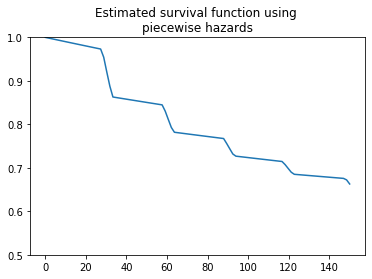

In [21]:
t = np.linspace(.001, 150, 100)
plt.plot(t, survival_function(estimates_, t))
plt.ylim(0.5, 1)
plt.title("""Estimated survival function using \npiecewise hazards""");

On day 30, we charge users \\$10, and on every 30 days after that, we charge \\$20. What's the LTV, and CIs, at the end of day 120?

In [33]:
def LTV_120(params):
    ltv = 0
    ltv += 10 * survival_function(params, 30)
    for t in [60, 90, 120]:
        ltv += 20 * survival_function(params, t)
    return ltv

In [38]:
ltv_ = LTV_120(estimates_)
print("LTV estimate: ", ltv_)

LTV estimate:  [54.60832347]


In [39]:
from autograd import grad
var_ltv_= grad(LTV_120)(estimates_) @ variance_matrix_ @ grad(LTV_120)(estimates_)
print("Variance LTV estimate:", var_ltv_)

Variance LTV estimate: 0.14292593736089781


In [37]:
std_ltv = np.sqrt(var_ltv_)
print("Estimated LTV at day 120: ($%.2f, $%.2f)" % (ltv_ - 1.96 * std_ltv, ltv_ + 1.96 * std_ltv))

Estimated LTV at day 120: ($53.87, $55.35)
